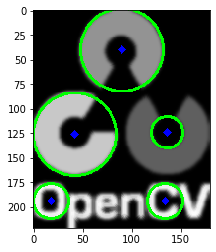

In [56]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### パス設定
filename = 'logo.png'

### 関数定義
# リサイズ処理
def reize(img_org, scale_width, scale_height):
  height = img_org.shape[0] #高さ
  width = img_org.shape[1] #幅
  #height, width, ch = img.shape #画像の大きさを取得
  img = cv2.resize(img_org, (int(width*scale_width), int(height*scale_height))) #リサイズ
  #trim_img = img[100:height, 100:width] #トリミング 
  return img  

# 重みフィルタ処理
def setWeightFilter(img, isGaussian, isMedian, isThreshold, isDilate):
  if isGaussian:
    img = cv2.GaussianBlur(img, (9, 9), 0) #ガウシアンフィルタ 第2引数はカーネル、第3引数は標準偏差
  if isMedian:
    img = cv2.medianBlur(img,5) #メディアンフィルタ
  #if isThreshold:
    #ret, threshold_img = cv2.threshold(gry_img, filter_threshold[1], filter_threshold[2], cv2.THRESH_OTSU) #２値化 第2,3引数は閾値、第4引数は手法のフ
  if isDilate:
    kernel = np.ones((3,3),np.uint8)
    img = cv2.dilate(img,kernel,iterations = 1) #膨張
  return img

# 指定色範囲抽出
def extractColor(img_org, lower_color, upper_color):
  # 指定した色範囲のみを抽出する
  img = cv2.inRange(img_org, lower_color, upper_color)
  return img
   
# ノイズフィルタ設定
def setNoiseFilter(img):
  # オープニング・クロージングによるノイズ除去
  element8 = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], np.uint8)
  img = cv2.morphologyEx(img, cv2.MORPH_OPEN, element8)
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, element8)
  return img

# エッジ検出
def extractEdge(img):
  img = cv2.Canny(img, 50, 110) #第2,3引数は閾値
  return img

# グラフ表示
def dispHystgram(Areas, Circularities, Eq_diameters):
  fig = plt.figure(figsize=(8,6))
  plt.subplot(2,2,1)
  plt.title("Areas (px^2)")
  plt.hist(Areas, bins=25, range=(0,150), rwidth=0.7)
  plt.subplot(2,2,2)
  plt.title("Circularity")
  plt.hist(Circularities, bins=25, range=(0.5,1), rwidth=0.7)
  plt.subplot(2,2,3)
  plt.title("Equal Diameters (px)")
  plt.hist(Eq_diameters, bins=25, range=(3.0, 15.0), rwidth=0.7)

#面積、円形度、等価直径算出
def calcCircle(contours):
  Areas = []
  Circularities = []
  Eq_diameters = []

  for i in contours:
    #面積(px*px)
    area = cv2.contourArea(i)
    Areas.append(area)

    #円形度
    arc = cv2.arcLength(i, True)
    circularity = 4 * np.pi * area / (arc * arc)
    Circularities.append(circularity)

    #等価直径(px)
    eq_diameter = np.sqrt(4*area/np.pi)
    Eq_diameters.append(eq_diameter)
  
  dispHystgram(Areas, Circularities, Eq_diameters)
  
  return Areas, Circularities, Eq_diameters

# ハフ変換による円検出
def getHoughCircle(img):
  circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,param1=50,param2=30,minRadius=0,maxRadius=0)
  circles = np.uint16(np.around(circles))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #RGBからBGRに変換
  # 描画
  for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
  return img
    
#最小外接円による円検出
def getMinScribedCircle(img):
  MIN_RADIUS = 25
 
  # 輪郭抽出
  c = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  img = c[0]
  contours = c[1]
  #hierarchy = c[2]    

  print("{} contours.".format(len(contours)))
 
  if len(contours) > 0:
    # 一番大きい赤色領域を指定する
    #contours.sort(key=cv2.contourArea, reverse=True)
    #cnt = contours[0]
 
    # 最小外接円を用いて円を検出する
    m = cv2.minEnclosingCircle(contours)
    (x, y) = m[0]
    radius = m[1]
    center = (int(x), int(y))
    radius = int(radius)
 
    # 円が小さすぎたら円を検出していないとみなす
    if radius < MIN_RADIUS:
      return None
    else:
      calcCircle(contours)
      return img, center, radius
  else:
    return None

### メインルーチン
img = cv2.imread(filename, 0) #画像読込　imreadの第2引数に0を指定するとグレースケールで読み込み
#img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #HSV情報に変換
#img = reize(img, 1.0, 1.0) #サイズ処理
img = setWeightFilter(img, True, True, False, False) #重みフィルタ処理
#img = setNoiseFilter(img) #ノイズフィルタ処理
#img = extractEdge(img) # エッジ検出
img = getHoughCircle(img)  #ハフ変換円検出
#c = getMinScribedCircle(img) #最小外接円検出

### 表示
plt.gray() #matplotlibでグレースケールを使用する場合はグレースケールで読み込むように指定
plt.imshow(img)
